# Data loading

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [ ]:
# Download dataset
!wget https://raw.githubusercontent.com/senyakk/Gogol-GPT/main/gogol.txt

--2023-07-06 21:59:02--  https://raw.githubusercontent.com/senyakk/Gogol-GPT/main/gogol.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342790 (335K) [text/plain]
Saving to: ‘gogol.txt’

gogol.txt           100%[===================>] 334.76K  --.-KB/s    in 0.03s   

2023-07-06 21:59:02 (10.1 MB/s) - ‘gogol.txt’ saved [342790/342790]



## Building vocabulary

In [ ]:
# Read dataset
with open('gogol.txt', 'r', encoding='cp1251') as file:
  text = file.read()

In [ ]:
# Split the long string per line and put in a list
corpus = text.lower().split("\n")

# Preview the result
print(corpus[:10])

['', 'н.в. гоголь. ревизор', '', 'николай васильевич гоголь', '', 'ревизор', '', '', 'на зеркало неча пенять, коли рожа крива. ', '', '\xa0\xa0\xa0\xa0народная пословица ', '', '', 'комедия в пяти действиях', '', '', 'действующие лица', '', 'антон антонович сквозник-дмухановский, городничий. ', '', 'анна андреевна, жена его. ', '', 'марья антоновна, дочь его. ', '', 'лука лукич хлопов, смотритель училищ. ', '', 'жена его. ', '', 'аммос федорович ляпкин-тяпкин, судья. ', '', 'артемий филиппович земляника, попечитель богоугодных заведений. ', '', 'иван кузьмич шпекин, почтмейстер. ', '', 'петр иванович добчинский, городской помещик.', '', 'петр иванович бобчинский,\xa0городской помещик.', '', 'иван александрович хлестаков, чиновник из петербурга. ', '', 'осип, слуга его. ', '', 'христиан иванович гибнер, уездный лекарь. ', '', 'федор иванович люлюков, отставной чиновник, почетное лицо в городе.', '', 'иван лазаревич растаковский, отставной чиновник, почетное лицо в городе.', '', 'степан 

In [ ]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'и': 1, 'не': 2, 'что': 3, 'в': 4, 'я': 5, 'а': 6, 'да': 7, 'как': 8, 'на': 9, 'с': 10, 'это': 11, 'так': 12, 'то': 13, 'вот': 14, 'ну': 15, 'вы': 16, 'нет': 17, 'же': 18, 'все': 19, 'ты': 20, 'уж': 21, 'у': 22, 'бы': 23, 'он': 24, 'ведь': 25, 'за': 26, 'хлестаков': 27, 'мне': 28, '–': 29, 'только': 30, 'еще': 31, 'к': 32, 'ж': 33, 'по': 34, 'кочкарев': 35, 'городничий': 36, 'его': 37, 'ли': 38, 'подколесин': 39, 'вам': 40, 'если': 41, 'меня': 42, 'теперь': 43, 'из': 44, 'нибудь': 45, 'вас': 46, 'утешительный': 47, 'есть': 48, 'чтобы': 49, 'тебе': 50, 'марья': 51, 'ничего': 52, 'агафья': 53, 'тихоновна': 54, 'ихарев': 55, 'анна': 56, 'андреевна': 57, 'явление': 58, 'человек': 59, 'но': 60, 'ни': 61, 'или': 62, 'иван': 63, '—': 64, 'было': 65, 'какой': 66, 'говорит': 67, 'иванович': 68, 'будет': 69, 'от': 70, 'тебя': 71, 'фекла': 72, '»': 73, 'ему': 74, 'там': 75, 'очень': 76, 'просто': 77, 'быть': 78, 'глов': 79, 'о': 80, 'черт': 81, 'право': 82, 'нужно': 83, 'ш

## Data preprocessing

In [ ]:
# Initialize the sequences list
input_sequences = []


for line in corpus:
	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):

		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Building Model

In [ ]:
# Hyperparameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = learning_rate), metrics=['accuracy'])

# Print the model summary
model.summary()

NameError: ignored

# Training

In [ ]:
epochs = 100
# Train the model
history = model.fit(xs, ys, epochs=epochs)

Epoch 1/50
1576/1576 [==============================] - 204s 123ms/step - loss: 7.6389 - accuracy: 0.0285
Epoch 2/50
1576/1576 [==============================] - 87s 55ms/step - loss: 7.1937 - accuracy: 0.0322
Epoch 3/50
1576/1576 [==============================] - 73s 46ms/step - loss: 7.0047 - accuracy: 0.0410
Epoch 4/50
1576/1576 [==============================] - 68s 43ms/step - loss: 6.8155 - accuracy: 0.0491
Epoch 5/50
1576/1576 [==============================] - 66s 42ms/step - loss: 6.6453 - accuracy: 0.0576
Epoch 6/50
1576/1576 [==============================] - 67s 43ms/step - loss: 6.4947 - accuracy: 0.0675
Epoch 7/50
1576/1576 [==============================] - 67s 42ms/step - loss: 6.3502 - accuracy: 0.0768
Epoch 8/50
1576/1576 [==============================] - 65s 41ms/step - loss: 6.2110 - accuracy: 0.0852
Epoch 9/50
1576/1576 [==============================] - 65s 41ms/step - loss: 6.0789 - accuracy: 0.0922
Epoch 10/50
1576/1576 [==============================] - 63s 4

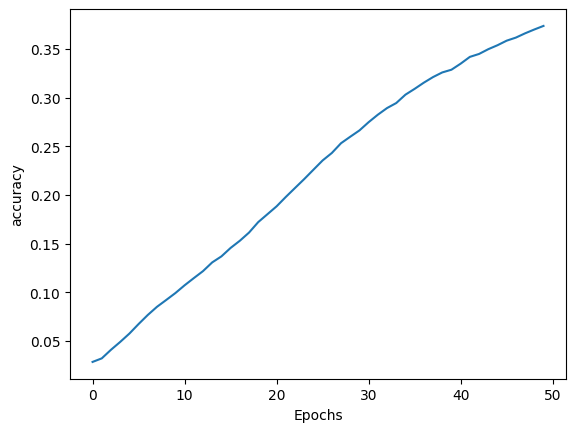

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

# Generating

In [ ]:
# Define seed text
seed_text = "Городничий. "

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

1/1 [==============================] - 0s 30ms/step
Городничий.  да вы не хочу чтобы он такой славный жених да шмыгнул в комнате там какая нибудь соус или пирожное бездельники дерут только на глаза и не сочинишь так вот ты сам никаких… однако ж ценить обхождение высшего общества ах ты ты сам что ты можешь матушка ли он как нибудь замолвить в комнате он уж бы было приступила ко мне и бить в халате и прочее» а впрочем ты ты однако ж ценить обхождение высшего общества ах ты ты сам ты сам только ли ты ты сам такие же ты верных получаешь полтораста тысяч чистоганом да ведь я не знаю


In [ ]:
# Define seed text
seed_text = "Городничий. "

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

		# Look up the word associated with the index.
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result
print(seed_text)

1/1 [==============================] - 0s 50ms/step
Laurence went to Dublin возьми нет тоже перекусил дороги дело с чернилами а потом сын утешительный и кровью а ведь необходимая вещь что ж если это за воротами иван производил что за пол ведь существуют же и полковника чеботарева по губам а короля и сам что она совсем иное чтобы он ухитрился как насядешь на ком… тысяч пождем не перебивайте возьми не могу объяснить ты побери этому что пойдешь на покаяние и подослала  — лекарств дорогих мне если бы было отправлено не можете ли я мне родня а ты такое ордена и все случаем вы я танцую еще что служит езекухтором такой уж мой
